Import Packages

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setting the current working directory
import os; os.chdir('drive/My Drive/NLP')

In [ ]:
pip install preprocessing

In [ ]:
pip install textpreprocess

In [ ]:
# Import packages
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style

import random, re
assert tf.__version__ >= '2.0'
%matplotlib inline

# Text preprocessing and stopwords
from textpreprocess import * #(custom module)

# Models
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set random state
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

!rm -R log/

rm: cannot remove 'log/': No such file or directory


Loading Dataset

In [ ]:
data = pd.read_json('./Sarcasm_Headlines_Dataset.json', lines = True)
print(f'Data has {data.shape[0]} rows and {data.shape[1]} columns. Here are the first five rows of the data...')
display(data.head())

Data has 28619 rows and 3 columns. Here are the first five rows of the data...


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


------------------------------------------------------------
Value Counts for `is_sarcastic` label
------------------------------------------------------------
Is Sarcastic count: 13634 i.e. 48.0%
Isn't Sarcastic count: 14985 i.e. 52.0%
------------------------------------------------------------
Distributon of `is_sarcastic` label
------------------------------------------------------------


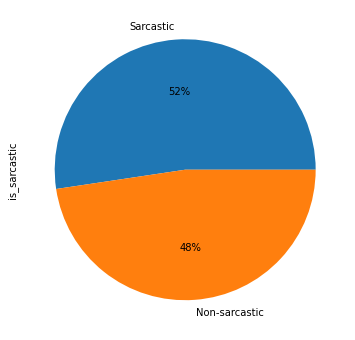

In [ ]:
print('--'*30); print('Value Counts for `is_sarcastic` label'); print('--'*30)
print(f'Is Sarcastic count: {data[data.is_sarcastic == 1].shape[0]} i.e. {round(data[data.is_sarcastic == 1].shape[0]/data.shape[0]*100, 0)}%')
print(f'Isn\'t Sarcastic count: {data[data.is_sarcastic == 0].shape[0]} i.e. {round(data[data.is_sarcastic == 0].shape[0]/data.shape[0]*100, 0)}%')

print('--'*30); print('Distributon of `is_sarcastic` label'); print('--'*30)
_ = data['is_sarcastic'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Sarcastic', 'Non-sarcastic'], figsize = (10, 6))

In [ ]:
print('Analysis of `is_sarcastic` label by news website'); print('--'*30)

hf = data[data['article_link'].str.contains('huffingtonpost.com')].shape[0]
op = data[data['article_link'].str.contains('theonion.com')].shape[0]

is_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 0)].shape[0]

is_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 0)].shape[0]

display(pd.DataFrame([[is_sarcastic_hf, is_sarcastic_op], [not_sarcastic_hf, not_sarcastic_op]], 
                     columns = ['huffingtonpost', 'theonion'], index = ['Sarcastic', 'Non-sarcastic']))

Analysis of `is_sarcastic` label by news website
------------------------------------------------------------


,huffingtonpost,theonion
Sarcastic,0,13634
Non-sarcastic,14985,1


In [ ]:
# Checking 5 random headlines and labels from the data
print('--'*30); print('Checking 5 random headlines and labels from the data'); print('--'*30)
rands = random.sample(range(1, data.shape[0]), 5)
headlines, labels = list(data.loc[rands, 'headline']), list(data.loc[rands, 'is_sarcastic'])

_ = [print(f'Headline: {head}\nlabel: {label}\n') for head, label in zip(headlines, labels)]

------------------------------------------------------------
Checking 5 random headlines and labels from the data
------------------------------------------------------------
Headline: i told my trump-supporting mom i'm having a biracial baby. here's what happened.
label: 0

Headline: mom thinks you'd enjoy restaurant she can't remember name of right now
label: 1

Headline: as more borders close, families rush for refuge
label: 0

Headline: new hallmark line addresses israeli-palestinian conflict
label: 1

Headline: shirtless mike huckabee spends entire debate seated in rickety rocking chair
label: 1



------------------------------------------------------------
Checking 5 random headlines and labels from the data where the length of headline is > 100
------------------------------------------------------------
Headline: trump vindicated after rest of leaked recording reveals him urging racial reconciliation, calling for interfaith dialogue, condemning gender inequality
label: 1

Headline: mackenzie bezos gains huge win in divorce settlement after successfully retaining no stake in 'washington post'
label: 1

Headline: alex jones struggling to convince skeptical police after witnessing actual murder in neighbor's backyard
label: 1

Headline: mike pence struggling to reckon with vision of prophet muhammad revealing that vp destined to become next president
label: 1

Headline: stumbling drunk chuck grassley warns kavanaugh accuser she can testify all she wants but no one's going to believe her
label: 1

------------------------------------------------------------
Distributon of label w

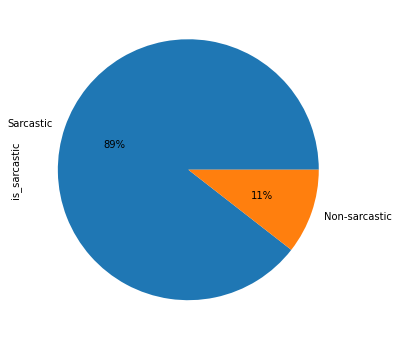

In [ ]:
# Checking 5 random headlines and labels from the data where the length of headline is > 100
print('--'*30); print('Checking 5 random headlines and labels from the data where the length of headline is > 100'); print('--'*30)
indexes = list(data.loc[data['headline'].str.len() > 100, 'headline'].index)
rands = random.sample(indexes, 5)
headlines, labels = list(data.loc[rands, 'headline']), list(data.loc[rands, 'is_sarcastic'])

_ = [print(f'Headline: {head}\nlabel: {label}\n') for head, label in zip(headlines, labels)]

print('--'*30); print('Distributon of label where the length of headline is > 100'); print('--'*30)
_ = data.loc[indexes, 'is_sarcastic'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Sarcastic', 'Non-sarcastic'], figsize = (10, 6))

**Observation**


Drop `article_link` from dataset.

In [ ]:
print('Dropping `article_link` from the data'); print('--'*30)
data.drop('article_link', axis = 1, inplace = True)

Dropping `article_link` from the data
------------------------------------------------------------


Data Preprocessing


In [ ]:
print('--'*30); print('Converting headlines to lower case')
data['cleaned_headline'] = data['headline'].apply(lambda x : x.lower())

print('Replacing apostrophes to the standard lexicons')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x : x.replace("'",""))

print('Removing punctuations')
punctuation = '!?,.:;"\')(_-'
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: x.translate(None, punctuation))

print('Applying Lemmatizer')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: lem(x))

print('Removing multiple spaces between words')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: re.sub(' +', ' ', x))

# print('Removing stopwords')
# data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: remove_stopwords(x))
print('--'*30)

SyntaxError: ignored

Get the Length of each line and find the maximum length

As different lines are of different length. We need to pad the our sequences using the max length.

In [ ]:
print('--'*40); print('Get the length of each line, find the maximum length and print the maximum length line'); 
print('Length of line ranges from 7 to 241.'); print('--'*40)
# Get length of each line
data['line_length'] = data['cleaned_headline'].str.len()

print('Minimum line length: {}'.format(data['line_length'].min()))
print('Maximum line length: {}'.format(data['line_length'].max()))
print('Line with maximum length: {}'.format(data[data['line_length'] == data['line_length'].max()]['cleaned_headline'].values[0]))

In [ ]:
print('--'*40); print('Get the number of words, find the maximum number of words and print the maximum number of words'); 
print('Number of words ranges from 2 to 39.'); print('--'*40)
# Get length of each line
data['nb_words'] = data['cleaned_headline'].apply(lambda x: len(x.split(' ')))

print('Minimum number of words: {}'.format(data['nb_words'].min()))
print('Maximum number of words: {}'.format(data['nb_words'].max()))
print('Line with maximum number of words: {}'.format(data[data['nb_words'] == data['nb_words'].max()]['cleaned_headline'].values[0]))

In [ ]:
print('Word Cloud of Sarcastic and Non-sarcastic Headlines')
data['headline'] = data['headline'].fillna('')
sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 1, 'cleaned_headline'])
plot_wordcloud(sarcastic_headlines, title = 'Word Cloud of Sarcastic Headlines')

non_sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 0, 'cleaned_headline'])
plot_wordcloud(non_sarcastic_headlines, title = 'Word Cloud of Isn\'t Sarcastic Headlines')

Modelling

In [ ]:
print('--'*30); print('Five point summary for number of words')
display(data['nb_words'].describe().round(0).astype(int)); 

print('99% quantilie: {}'.format(data['nb_words'].quantile(0.99)));print('--'*30)

In [ ]:
max_features = 10000
maxlen = data['nb_words'].max()
embedding_size = 200

Applying Keras Tokenizer 

In [ ]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(data['cleaned_headline']))

Define X and y for your model.

In [ ]:
X = tokenizer.texts_to_sequences(data['cleaned_headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

print(f'Number of Samples: {len(X)}')
print(f'Number of Labels: {len(y)}')
print(f'\nFirst headline:\n{X[0]}\n\nLabel of the first headline: {y[0]}')

Get the Vocabulary size

In [ ]:
# Reserve padding (indexed zero)
w2i = tokenizer.word_index
vocab_size = len(w2i) + 1
print(f'Number of unique tokens: {vocab_size}')

Get Glove Word Embeddings

In [ ]:
glove_file = './Data/glove.6B.zip'

In [ ]:
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

Get word embeddings using embedding file

In [ ]:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(' ')[0]
    embd = o.split(' ')[1:]
    embd = np.asarray(embd, dtype = 'float32')
    embeddings[word] = embd

Create a weight matrix

In [ ]:
# Getting the minimum number of words
num_words = min(max_features, vocab_size) + 1

embedding_matrix = np.zeros((num_words, embedding_size))
for word, i in tokenizer.word_index.items():
    if i > max_features: continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

Create and Compile Model


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)

print('---'*20, f'\nNumber of rows in training dataset: {x_train.shape[0]}')
print(f'Number of columns in training dataset: {x_train.shape[1]}')
print(f'Number of unique words in training dataset: {len(np.unique(np.hstack(x_train)))}')

print('---'*20, f'\nNumber of rows in test dataset: {x_test.shape[0]}')
print(f'Number of columns in test dataset: {x_test.shape[1]}')
print(f'Number of unique words in test dataset: {len(np.unique(np.hstack(x_test)))}')

In [ ]:
model = Sequential()
model.add(Embedding(num_words, embedding_size, embeddings_initializer = Constant(embedding_matrix), input_length = maxlen, trainable = False))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5, input_shape = (256,)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (128,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (64,)))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Adding callbacks
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)  
mc = ModelCheckpoint('sarcasm_detector.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)
lr_r = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5),
logdir = 'log'; tb = TensorBoard(logdir, histogram_freq = 1)
callbacks = [es, mc, lr_r, tb]

print(model.summary())

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

Fitting model

In [ ]:
batch_size = 100
epochs = 6

h = model.fit(x_train, y_train, epochs = epochs, validation_split = 0.2, batch_size = batch_size, verbose = 2, callbacks = callbacks)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir log/

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7.2))
f.suptitle('Monitoring the performance of the model')

ax1.plot(h.history['loss'], label = 'Train')
ax1.plot(h.history['val_loss'], label = 'Test')
ax1.set_title('Model Loss')
ax1.legend(['Train', 'Test'])

ax2.plot(h.history['accuracy'], label = 'Train')
ax2.plot(h.history['val_accuracy'], label = 'Test')
ax2.set_title('Model Accuracy')
ax2.legend(['Train', 'Test'])

plt.show()

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose = 0)
print('Overall Accuracy: {}'.format(round(accuracy * 100, 0)))

In [ ]:
y_pred = (model.predict(x_test) > 0.5).astype('int32')
print(f'Classification Report:\n{classification_report(y_pred, y_test)}')

In [ ]:
print('--'*30); print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm , index = ['Non-sarcastic', 'Sarcastic'] , columns = ['Non-sarcastic','Sarcastic'])
display(cm); print('--'*30)

plt.figure(figsize = (8, 5))
_ = sns.heatmap(cm, cmap= 'Blues', linecolor = 'black' , linewidth = 1 , annot = True, 
            fmt = '' , xticklabels = ['Non-sarcastic', 'Sarcastic'], 
            yticklabels = ['Non-sarcastic', 'Sarcastic']).set_title('Confusion Matrix')

In [ ]:
print('Evaluate model on sample sarcastic lines'); print('--'*30)
statements = ['Are you always so stupid or is today a special ocassion?', #Sarcasm
              'I feel so miserable without you, it\'s almost like having you here.', #Sarcasm
              'If you find me offensive. Then I suggest you quit finding me.', #Sarcasm
              'If I wanted to kill myself I would climb your ego and jump to your IQ.', #Sarcasm
              'Amphibious pitcher makes debut', #Sarcasm
              'It\'s okay if you don\'t like me. Not everyone has good taste.' #Sarcasm
              ]

for statement in statements:
  statement = statement.lower()
  statement = replace_words(statement)
  statement = remove_punctuation(statement)
  statement = lem(statement)
  statement = re.sub(' +', ' ', statement)

  headline = tokenizer.texts_to_sequences(statement)
  headline = pad_sequences(headline, maxlen = maxlen, dtype = 'int32', value = 0)

  sentiment = (model.predict(headline) > 0.5).astype('int32')
  if(np.argmax(sentiment) == 0):
      print(f'`{statement}` is a Non-sarcastic statement.')
  elif (np.argmax(sentiment) == 1):
      print(f'`{statement}` is a Sarcastic statement.')